## Creating a PyTorch CNN ADT model

## Loading and preprocessing the data

In [155]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchvision
import torch_audiomentations
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import librosa
import os
import csv
import random

The `n_fft` variable affects the n_fft parameter used in generating melspectrograms and MFCC features used in training and validation. I found the value of `1024` works best, but `2048` can also work well.

In [156]:
dataset_name = "HeartsOnFireDS-v.1.0.4"
n_fft = 1024

df = pd.read_csv(os.path.join(dataset_name, "master.csv"))
train_df = pd.DataFrame()
valid_df = pd.DataFrame()

for idx, row in df.iterrows():
    onsets_path = row['onsets']
    onsets_df = pd.read_csv(onsets_path)
    train_onsets = onsets_df[onsets_df['split'] == 'training']
    valid_onsets = onsets_df[onsets_df['split'] == 'validation']
    
    # Append to respective dataframes
    train_df = pd.concat([train_df, train_onsets], ignore_index=True)
    valid_df = pd.concat([valid_df, valid_onsets], ignore_index=True)

train_df

,onset_time,kick,snare,hihat,tom,crash,ride,other,name,changed,split,Unnamed: 0,click,uncertain
0,0.766259,True,False,True,False,False,False,False,Atsushi Kitajoh - I'll Face Myself (-Battle-),True,training,NaN,NaN,NaN
1,0.963628,False,False,True,False,False,False,False,Atsushi Kitajoh - I'll Face Myself (-Battle-),True,training,NaN,NaN,NaN
2,1.149388,False,False,True,False,False,False,False,Atsushi Kitajoh - I'll Face Myself (-Battle-),True,training,NaN,NaN,NaN
3,1.335147,True,False,True,False,False,False,False,Atsushi Kitajoh - I'll Face Myself (-Battle-),True,training,NaN,NaN,NaN
4,1.532517,False,True,True,False,False,False,False,Atsushi Kitajoh - I'll Face Myself (-Battle-),True,training,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5908,209.142132,False,False,False,True,False,False,False,Toehider - To Hide Her,True,training,858.0,NaN,NaN
5909,209.235011,False,False,False,True,False,False,False,Toehider - To Hide Her,True,training,859.0,NaN,NaN
5910,209.304671,False,False,False,True,False,False,False,Toehider - To Hide Her,True,training,860.0,NaN,NaN
5911,209.397551,True,False,False,False,True,False,False,Toehider - To Hide Her,True,training,861.0,NaN,NaN


### Setting custom weights based on the amount of classes in dataset

Also possible to alter the weight of the cymbal classes to force the model to be more accurate at classifying them.

In [157]:
counts = train_df.select_dtypes(include=bool).sum(axis=0)
counts = counts.drop(['other', 'changed'])
weights = counts.sum() / (counts * len(counts))
weights_tensor = torch.Tensor(list(weights.values))
#weights_tensor[2] = 1.0 # giving extra weight to the hihat class
weights_tensor

tensor([0.4530, 0.7197, 0.6041, 3.6896, 2.6700, 9.8029])

### Defining the dataset class with a custom transform pipeline

Note the `torch_audiomentations` transforms are implemented differently than the rest of the transforms, requiring the input tensors to be 4D: `[batch, num_channels, freq, time]`. Since we only have a 2D tensor of `[freq, time]`, we will add the extra dimensions and then remove them after we added the necessary data augmentation transforms. 

Bit of a cheaty solution, but I found this method performs the fastest if performed within the transform pipeline.

In [214]:
train_transform_mfccs = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda x: x.to("cuda")),
    torchvision.transforms.Lambda(lambda x: x.unsqueeze(0).unsqueeze(0)),
    torch_audiomentations.AddColoredNoise(
                min_snr_in_db=3,
                max_snr_in_db=12,
                sample_rate=44100,
                p=0.5,
                output_type='tensor'
            ).to("cuda"),
    # torch_audiomentations.Shift(
    #         min_shift=-0.15,
    #         max_shift=0.15,
    #         rollover=False,
    #         p=0.5,
    #         sample_rate=44100,
    #         output_type='tensor'
    #     ).to("cuda"),
    torch_audiomentations.PitchShift(
            min_transpose_semitones=-1,
            max_transpose_semitones=1,
            p=0.25,
            sample_rate=44100,
            output_type='tensor'
        ).to("cuda"),
    torch_audiomentations.Gain(min_gain_in_db=-6, p=0.5, output_type='tensor').to("cuda"),
    torchvision.transforms.Lambda(lambda x: x.squeeze(0).squeeze(0)),
    torchvision.transforms.Lambda(lambda x: torch.stack([
            torchaudio.transforms.MelSpectrogram(
                n_fft=n_fft,
                hop_length=64,
                n_mels=128
            ).to("cuda")(x),
            torchaudio.transforms.MFCC(
                n_mfcc=128,
                melkwargs={'n_fft': n_fft, 'hop_length': 64, 'n_mels': 128}
            ).to("cuda")(x)
            ], dim=0).to("cuda")),
    torchvision.transforms.Lambda(lambda x: torch.stack([
            torchaudio.transforms.AmplitudeToDB().to("cuda")(x[0]),
            x[0],
            x[1]
        ], dim=0).to("cuda")),
    torchvision.transforms.Lambda(lambda x: x.to("cpu")),
])

valid_transform_mfccs = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda x: x.to("cuda")),
    torchvision.transforms.Lambda(lambda x: torch.stack([
            torchaudio.transforms.MelSpectrogram(
                n_fft=n_fft,
                hop_length=64,
                n_mels=128
            ).to("cuda")(x),
            torchaudio.transforms.MFCC(
                n_mfcc=128,
                melkwargs={'n_fft': n_fft, 'hop_length': 64, 'n_mels': 128}
            ).to("cuda")(x)
            ], dim=0).to("cuda")),
    torchvision.transforms.Lambda(lambda x: torch.stack([
            torchaudio.transforms.AmplitudeToDB().to("cuda")(x[0]),
            x[0],
            x[1]
        ], dim=0).to("cuda")),
    torchvision.transforms.Lambda(lambda x: x.to("cpu"))
])

fast_transform = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda x: x.to("cuda")),
    torchvision.transforms.Lambda(lambda x: torch.stack([
            torchaudio.transforms.MelSpectrogram(
                n_fft=n_fft,
                hop_length=64,
                n_mels=128
            ).to("cuda")(x)
        ], dim=0).to("cuda")),
    torchvision.transforms.Lambda(lambda x: torch.stack([
            torchaudio.transforms.AmplitudeToDB().to("cuda")(x[0]),
            x[0],
        ], dim=0).to("cuda")),
    torchvision.transforms.Lambda(lambda x: x.to("cpu"))
])

In [221]:
drum_labels = ['kick', 'snare', 'hihat', 'tom', 'crash', 'ride']

class DrumDataset(Dataset):
    def __init__(self, df, master_csv_path, transform, window_size=8192):
        self.df = df
        self.master_df = pd.read_csv(master_csv_path)
        self.window_size = window_size
        self.transform = transform
        self.audio_cache = {}

        for i, row in self.master_df.iterrows():
            audio_path = row['drums']
            audio, sr = torchaudio.load(audio_path, format="mp3")
            if audio.shape[0] == 2:
                audio = torch.mean(audio, dim=0, keepdim=True)
            self.audio_cache[row['name']] = (audio, sr)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Load the onset time, label, and track name for the given index
        row = self.df.iloc[idx]
        onset_time = row['onset_time']
        labels = row[drum_labels].astype(int).values.flatten()
        labels = torch.tensor(labels).float()
        track_name = row['name']
        #print(track_name, onset_time)

        audio = self.audio_cache[track_name][0]
        sr = self.audio_cache[track_name][1]

        onset_window = audio[:, int(onset_time*sr)-self.window_size//2:int(onset_time*sr)+self.window_size//2]
        spec = self.transform(onset_window[0])
        return spec, labels

valid_dataset = DrumDataset(valid_df, os.path.join(dataset_name, "master.csv"), valid_transform_mfccs)
train_dataset = DrumDataset(train_df, os.path.join(dataset_name, "master.csv"), valid_transform_mfccs)

### Getting a random onset and displaying the melspectrogram

1813 tensor([1., 0., 1., 0., 0., 0.])


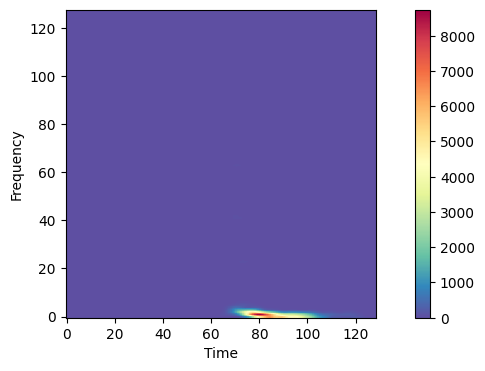

In [222]:
rand = random.randint(1, len(train_df))
a, x = train_dataset.__getitem__(rand)
specgram = a[1].detach().squeeze(0).numpy()
print(rand, x)

plt.figure(figsize=(10, 4))
plt.imshow(specgram, cmap='Spectral_r', origin='lower')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()

## Defining the model architecture

### Model A

**Initial filter size:** `16`

In [223]:
# Define the neural network architecture
class DrumCNN(nn.Module):
    def __init__(self):
        super(DrumCNN, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1) # input channels
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.relu5 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.relu6 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)
        
        self.fc3 = nn.Linear(256, len(drum_labels))
    
    def forward(self, x):
        # Convolutional Layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully Connected Layers
        x = self.fc1(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        
        return x

device = torch.device('cuda')

### Model B

**Initial filter size:** `32`

Thought about increasing the initial filter size to help with identifying hi-hats, performance is worse by 2-4% compared to Model A. Only run the following cell if you want to override Model A.

In [5]:
class DrumCNN(nn.Module):
    def __init__(self):
        super(DrumCNN, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.relu5 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.relu6 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.4)
        
        self.fc3 = nn.Linear(256, len(drum_labels))
    
    def forward(self, x):
        # Convolutional Layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully Connected Layers
        x = self.fc1(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        
        return x

## Training

### Hyperparameters

In [224]:
n_epochs = 50
learning_rate = 0.001
batch_size = 32

### Loss function, optimizer, scheduler

In [225]:
def accuracy(outputs, labels, threshold=0.0):
    with torch.no_grad():
        preds = (outputs > threshold).float()
        correct = (preds == labels).sum(dim=1).eq(labels.shape[1]).sum().item()
        total = labels.shape[0]
        return 100 * correct / total

# Create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Initialize the neural network and optimizer
model = DrumCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)
start_epoch = 0
valid_loss = 0.0

# Define the loss function
criterion = nn.BCEWithLogitsLoss(weight=weights_tensor.to(device))

### Loading previous checkpoint to continue training

In [152]:
saved_model_dict = torch.load('models/HeartsOnFire-v.1.0.4_nfft1024_91.58.pth', map_location=device)
model.load_state_dict(saved_model_dict['model'])
scheduler.load_state_dict(saved_model_dict['scheduler'])
optimizer.load_state_dict(saved_model_dict['optimizer'])
start_epoch = saved_model_dict['epoch']
n_epochs += start_epoch+1

### Main loop

In [226]:
max_acc = 89.00

for epoch in range(start_epoch, n_epochs):
    train_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0

    model.train()
    for i, (inputs, labels) in enumerate(tqdm(train_loader, total=len(train_loader), unit='batch', desc=f"Epoch {epoch+1}/{n_epochs} Training")):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        train_acc += accuracy(outputs, labels) * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)
    # Evaluate the model on the validation set
    true_labels = []
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(valid_loader, total=len(valid_loader), unit='batch', desc=f"Epoch {epoch+1}/{n_epochs} Validation")):
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            valid_acc += accuracy(outputs, labels) * inputs.size(0)
            true_labels.extend(labels.cpu().numpy().tolist())
            predicted_labels.extend((outputs.cpu() > 0.0).float().numpy().tolist())
        valid_loss /= len(valid_loader.dataset)
        valid_acc /= len(valid_loader.dataset)

        cm = multilabel_confusion_matrix(true_labels, predicted_labels)
        f, axes = plt.subplots(1, 6, figsize=(25, 6))
        axes = axes.ravel()
        for i in range(len(drum_labels)):
            disp = ConfusionMatrixDisplay(cm[i], display_labels=[0, 1])
            disp.plot(ax=axes[i], values_format='.4g')
            disp.ax_.set_title(drum_labels[i])
            disp.im_.colorbar.remove()

        plt.subplots_adjust(wspace=0.10, hspace=0.1)
        f.colorbar(disp.im_, ax=axes)
        plt.savefig(f'cm_e{epoch+1}.png')
        plt.close()
    
    # Update the learning rate based on the validation loss
    scheduler.step(valid_loss)
    
    # Print the training and validation loss and accuracy
    tqdm.write(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%')

    if valid_acc > max_acc:
        checkpoint = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'epoch': epoch
        }
        max_acc = valid_acc
        torch.save(checkpoint, f'models/{dataset_name}_nfft1024_{valid_acc:.2f}.pth')

Epoch 1/50 Validation: 100%|██████████| 47/47 [00:15<00:00,  3.02batch/s]


Epoch 1/50, Train Loss: 0.5508, Train Acc: 47.29%, Valid Loss: 0.2768, Valid Acc: 72.32%


Epoch 2/50 Validation: 100%|██████████| 47/47 [00:14<00:00,  3.15batch/s]


Epoch 2/50, Train Loss: 0.2576, Train Acc: 70.12%, Valid Loss: 0.2117, Valid Acc: 74.21%


Epoch 3/50 Validation: 100%|██████████| 47/47 [00:15<00:00,  3.05batch/s]


Epoch 3/50, Train Loss: 0.2049, Train Acc: 74.26%, Valid Loss: 0.1667, Valid Acc: 80.88%


Epoch 4/50 Validation: 100%|██████████| 47/47 [00:14<00:00,  3.14batch/s]


Epoch 4/50, Train Loss: 0.1734, Train Acc: 75.75%, Valid Loss: 0.1668, Valid Acc: 80.74%


Epoch 5/50 Validation: 100%|██████████| 47/47 [00:14<00:00,  3.14batch/s]


Epoch 5/50, Train Loss: 0.1504, Train Acc: 78.72%, Valid Loss: 0.1402, Valid Acc: 85.05%


Epoch 6/50 Validation: 100%|██████████| 47/47 [00:15<00:00,  3.08batch/s]


Epoch 6/50, Train Loss: 0.1381, Train Acc: 80.11%, Valid Loss: 0.1307, Valid Acc: 83.91%


Epoch 7/50 Validation: 100%|██████████| 47/47 [00:15<00:00,  2.99batch/s]


Epoch 7/50, Train Loss: 0.1186, Train Acc: 81.87%, Valid Loss: 0.1247, Valid Acc: 85.45%


Epoch 8/50 Validation: 100%|██████████| 47/47 [00:15<00:00,  3.05batch/s]


Epoch 8/50, Train Loss: 0.1146, Train Acc: 82.34%, Valid Loss: 0.1381, Valid Acc: 84.78%


Epoch 9/50 Validation: 100%|██████████| 47/47 [00:15<00:00,  3.06batch/s]


Epoch 9/50, Train Loss: 0.0972, Train Acc: 84.10%, Valid Loss: 0.1274, Valid Acc: 84.98%


Epoch 10/50 Validation: 100%|██████████| 47/47 [00:15<00:00,  3.07batch/s]


Epoch 10/50, Train Loss: 0.0889, Train Acc: 84.39%, Valid Loss: 0.1372, Valid Acc: 85.25%


Epoch 11/50 Validation: 100%|██████████| 47/47 [00:14<00:00,  3.22batch/s]


Epoch 11/50, Train Loss: 0.0721, Train Acc: 86.76%, Valid Loss: 0.1173, Valid Acc: 87.88%


Epoch 12/50 Validation: 100%|██████████| 47/47 [00:16<00:00,  2.86batch/s]


Epoch 12/50, Train Loss: 0.0616, Train Acc: 88.08%, Valid Loss: 0.1140, Valid Acc: 87.95%


Epoch 13/50 Validation: 100%|██████████| 47/47 [00:15<00:00,  3.12batch/s]


Epoch 13/50, Train Loss: 0.0559, Train Acc: 88.47%, Valid Loss: 0.1124, Valid Acc: 88.35%


Epoch 14/50 Validation: 100%|██████████| 47/47 [00:15<00:00,  3.05batch/s]


Epoch 14/50, Train Loss: 0.0538, Train Acc: 88.45%, Valid Loss: 0.1113, Valid Acc: 88.08%


Epoch 15/50 Validation: 100%|██████████| 47/47 [00:15<00:00,  3.09batch/s]


Epoch 15/50, Train Loss: 0.0500, Train Acc: 89.82%, Valid Loss: 0.1116, Valid Acc: 88.42%


Epoch 16/50 Validation: 100%|██████████| 47/47 [00:16<00:00,  2.86batch/s]


Epoch 16/50, Train Loss: 0.0483, Train Acc: 89.90%, Valid Loss: 0.1154, Valid Acc: 87.74%


Epoch 17/50 Validation: 100%|██████████| 47/47 [00:16<00:00,  2.87batch/s]


Epoch 17/50, Train Loss: 0.0466, Train Acc: 89.75%, Valid Loss: 0.1183, Valid Acc: 88.22%


Epoch 18/50 Validation: 100%|██████████| 47/47 [00:15<00:00,  3.12batch/s]


Epoch 18/50, Train Loss: 0.0462, Train Acc: 89.90%, Valid Loss: 0.1148, Valid Acc: 88.22%


Epoch 19/50 Validation: 100%|██████████| 47/47 [00:14<00:00,  3.18batch/s]


Epoch 19/50, Train Loss: 0.0425, Train Acc: 90.77%, Valid Loss: 0.1136, Valid Acc: 88.08%


Epoch 20/50 Validation: 100%|██████████| 47/47 [00:14<00:00,  3.16batch/s]


Epoch 20/50, Train Loss: 0.0445, Train Acc: 90.58%, Valid Loss: 0.1127, Valid Acc: 88.28%


Epoch 21/50 Validation: 100%|██████████| 47/47 [00:14<00:00,  3.28batch/s]


Epoch 21/50, Train Loss: 0.0428, Train Acc: 90.73%, Valid Loss: 0.1145, Valid Acc: 88.48%


Epoch 22/50 Validation: 100%|██████████| 47/47 [00:15<00:00,  3.09batch/s]


Epoch 22/50, Train Loss: 0.0435, Train Acc: 90.38%, Valid Loss: 0.1143, Valid Acc: 88.35%


Epoch 23/50 Validation: 100%|██████████| 47/47 [00:14<00:00,  3.27batch/s]


Epoch 23/50, Train Loss: 0.0429, Train Acc: 90.56%, Valid Loss: 0.1128, Valid Acc: 88.62%


Epoch 24/50 Validation: 100%|██████████| 47/47 [00:15<00:00,  3.11batch/s]


Epoch 24/50, Train Loss: 0.0444, Train Acc: 90.60%, Valid Loss: 0.1114, Valid Acc: 88.48%


Epoch 25/50 Validation: 100%|██████████| 47/47 [00:14<00:00,  3.35batch/s]


Epoch 25/50, Train Loss: 0.0409, Train Acc: 90.51%, Valid Loss: 0.1112, Valid Acc: 88.48%


Epoch 26/50 Validation: 100%|██████████| 47/47 [00:14<00:00,  3.16batch/s]


Epoch 26/50, Train Loss: 0.0433, Train Acc: 90.41%, Valid Loss: 0.1136, Valid Acc: 88.69%


Epoch 27/50 Validation: 100%|██████████| 47/47 [00:14<00:00,  3.28batch/s]


Epoch 27/50, Train Loss: 0.0423, Train Acc: 90.94%, Valid Loss: 0.1121, Valid Acc: 88.08%


Epoch 28/50 Validation: 100%|██████████| 47/47 [00:13<00:00,  3.41batch/s]


Epoch 28/50, Train Loss: 0.0439, Train Acc: 90.11%, Valid Loss: 0.1139, Valid Acc: 88.15%


Epoch 29/50 Validation: 100%|██████████| 47/47 [00:14<00:00,  3.30batch/s]


Epoch 29/50, Train Loss: 0.0409, Train Acc: 90.92%, Valid Loss: 0.1111, Valid Acc: 88.42%


Epoch 30/50 Validation: 100%|██████████| 47/47 [00:14<00:00,  3.24batch/s]


Epoch 30/50, Train Loss: 0.0403, Train Acc: 90.80%, Valid Loss: 0.1138, Valid Acc: 88.08%


Epoch 31/50 Validation: 100%|██████████| 47/47 [00:14<00:00,  3.17batch/s]


Epoch 31/50, Train Loss: 0.0434, Train Acc: 90.07%, Valid Loss: 0.1150, Valid Acc: 88.42%


Epoch 32/50 Validation: 100%|██████████| 47/47 [00:14<00:00,  3.16batch/s]


Epoch 32/50, Train Loss: 0.0434, Train Acc: 90.85%, Valid Loss: 0.1103, Valid Acc: 88.35%


Epoch 33/50 Validation: 100%|██████████| 47/47 [00:14<00:00,  3.24batch/s]


Epoch 33/50, Train Loss: 0.0437, Train Acc: 90.51%, Valid Loss: 0.1119, Valid Acc: 88.48%


Epoch 34/50 Validation: 100%|██████████| 47/47 [00:14<00:00,  3.16batch/s]


Epoch 34/50, Train Loss: 0.0421, Train Acc: 90.99%, Valid Loss: 0.1133, Valid Acc: 88.28%


Epoch 35/50 Validation: 100%|██████████| 47/47 [00:14<00:00,  3.18batch/s]


Epoch 35/50, Train Loss: 0.0444, Train Acc: 90.68%, Valid Loss: 0.1134, Valid Acc: 88.15%


Epoch 36/50 Validation: 100%|██████████| 47/47 [00:15<00:00,  3.03batch/s]


Epoch 36/50, Train Loss: 0.0414, Train Acc: 90.80%, Valid Loss: 0.1144, Valid Acc: 88.62%


Epoch 37/50 Validation: 100%|██████████| 47/47 [00:14<00:00,  3.19batch/s]


Epoch 37/50, Train Loss: 0.0432, Train Acc: 90.19%, Valid Loss: 0.1134, Valid Acc: 88.62%


Epoch 38/50 Validation: 100%|██████████| 47/47 [00:14<00:00,  3.27batch/s]


Epoch 38/50, Train Loss: 0.0441, Train Acc: 90.43%, Valid Loss: 0.1122, Valid Acc: 88.01%


Epoch 39/50 Validation: 100%|██████████| 47/47 [00:14<00:00,  3.18batch/s]


Epoch 39/50, Train Loss: 0.0430, Train Acc: 90.55%, Valid Loss: 0.1145, Valid Acc: 88.42%


Epoch 40/50 Validation: 100%|██████████| 47/47 [00:14<00:00,  3.16batch/s]


Epoch 40/50, Train Loss: 0.0433, Train Acc: 90.46%, Valid Loss: 0.1130, Valid Acc: 88.28%


Epoch 41/50 Validation: 100%|██████████| 47/47 [00:15<00:00,  3.04batch/s]


Epoch 41/50, Train Loss: 0.0432, Train Acc: 90.41%, Valid Loss: 0.1146, Valid Acc: 88.35%


Epoch 42/50 Validation: 100%|██████████| 47/47 [00:14<00:00,  3.24batch/s]


Epoch 42/50, Train Loss: 0.0427, Train Acc: 90.29%, Valid Loss: 0.1145, Valid Acc: 88.48%


Epoch 43/50 Validation: 100%|██████████| 47/47 [00:14<00:00,  3.17batch/s]


Epoch 43/50, Train Loss: 0.0436, Train Acc: 90.94%, Valid Loss: 0.1149, Valid Acc: 88.42%


Epoch 44/50 Validation: 100%|██████████| 47/47 [00:14<00:00,  3.20batch/s]


Epoch 44/50, Train Loss: 0.0413, Train Acc: 91.39%, Valid Loss: 0.1160, Valid Acc: 88.82%


Epoch 45/50 Validation: 100%|██████████| 47/47 [00:14<00:00,  3.28batch/s]


Epoch 45/50, Train Loss: 0.0419, Train Acc: 90.68%, Valid Loss: 0.1137, Valid Acc: 88.55%


Epoch 46/50 Validation: 100%|██████████| 47/47 [00:15<00:00,  3.12batch/s]


Epoch 46/50, Train Loss: 0.0421, Train Acc: 90.51%, Valid Loss: 0.1144, Valid Acc: 88.35%


Epoch 47/50 Validation: 100%|██████████| 47/47 [00:14<00:00,  3.15batch/s]


Epoch 47/50, Train Loss: 0.0443, Train Acc: 90.24%, Valid Loss: 0.1156, Valid Acc: 88.62%


Epoch 48/50 Validation: 100%|██████████| 47/47 [00:15<00:00,  3.03batch/s]


Epoch 48/50, Train Loss: 0.0424, Train Acc: 90.85%, Valid Loss: 0.1122, Valid Acc: 88.48%


Epoch 49/50 Validation: 100%|██████████| 47/47 [00:14<00:00,  3.22batch/s]


Epoch 49/50, Train Loss: 0.0433, Train Acc: 90.73%, Valid Loss: 0.1121, Valid Acc: 88.42%


Epoch 50/50 Validation: 100%|██████████| 47/47 [00:14<00:00,  3.21batch/s]


Epoch 50/50, Train Loss: 0.0434, Train Acc: 90.83%, Valid Loss: 0.1141, Valid Acc: 88.42%


### Saving the model

In [220]:
checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'epoch': epoch
}
torch.save(checkpoint, f'models/{dataset_name}_nfft1024_{valid_acc:.2f}.pth')

## Labeling a dataset song with the model

I use this section to iteratively improve my dataset and model.

### Get onset times from dataset

In [20]:
name = "Pendulum - Crush (Devin Townsend Remix)"
label_onset_path = f"{dataset_name}/{name}/onsets.csv"
label_df = pd.read_csv(label_onset_path)
label_df["name"] = name
# label_df = label_df.iloc[1:]
# label_df = label_df.reset_index(drop=True)
label_df

,onset_time,kick,snare,hihat,tom,crash,ride,other,name
0,0.162540,False,False,False,False,False,False,False,Pendulum - Crush (Devin Townsend Remix)
1,0.255420,False,False,False,False,False,False,False,Pendulum - Crush (Devin Townsend Remix)
2,0.336689,False,False,False,False,False,False,False,Pendulum - Crush (Devin Townsend Remix)
3,0.417959,False,False,False,False,False,False,False,Pendulum - Crush (Devin Townsend Remix)
4,0.510839,False,False,False,False,False,False,False,Pendulum - Crush (Devin Townsend Remix)
...,...,...,...,...,...,...,...,...,...
913,204.289161,False,False,False,False,False,False,False,Pendulum - Crush (Devin Townsend Remix)
914,205.589478,False,False,False,False,False,False,False,Pendulum - Crush (Devin Townsend Remix)
915,206.913016,False,False,False,False,False,False,False,Pendulum - Crush (Devin Townsend Remix)
916,222.145306,False,False,False,False,False,False,False,Pendulum - Crush (Devin Townsend Remix)


### Load model checkpoint

In [14]:
checkpoint = torch.load('models/HeartsOnFire-v.1.0.3_nfft1024_89.76.pth')
model = DrumCNN().to(device)
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

### Load the onset times and label them with the model

In [21]:
labeling_dataset = DrumDataset(label_df, f"{dataset_name}/master.csv", fast_transform)
labeling_loader = DataLoader(labeling_dataset, batch_size=16, shuffle=False)

model.eval()
predicted_labels=[]
with torch.no_grad():
    for i, (inputs, labels) in enumerate(tqdm(labeling_loader, total=len(labeling_loader), unit='batch', desc=f"Labeling")):
        inputs = inputs.to(device)
        outputs = model(inputs)
        predicted_labels.extend((outputs>0.0).cpu().numpy().tolist())

Labeling: 100%|██████████| 58/58 [00:05<00:00, 10.39batch/s]


In [22]:
label_df[drum_labels] = predicted_labels
label_df

,onset_time,kick,snare,hihat,tom,crash,ride,other,name
0,0.162540,False,False,False,False,False,False,False,Pendulum - Crush (Devin Townsend Remix)
1,0.255420,True,False,False,False,False,False,False,Pendulum - Crush (Devin Townsend Remix)
2,0.336689,False,False,False,False,False,False,False,Pendulum - Crush (Devin Townsend Remix)
3,0.417959,False,True,False,False,False,False,False,Pendulum - Crush (Devin Townsend Remix)
4,0.510839,False,False,False,False,False,False,False,Pendulum - Crush (Devin Townsend Remix)
...,...,...,...,...,...,...,...,...,...
913,204.289161,False,True,False,False,False,False,False,Pendulum - Crush (Devin Townsend Remix)
914,205.589478,True,False,False,False,False,False,False,Pendulum - Crush (Devin Townsend Remix)
915,206.913016,False,False,False,False,False,False,False,Pendulum - Crush (Devin Townsend Remix)
916,222.145306,False,False,False,True,False,False,False,Pendulum - Crush (Devin Townsend Remix)


### Save the final result as an updated .csv file

The more the model improves, the less labeling I have to do. The minor corrections I DO have to perform, will be picked up on in the next iterations of the model.

In [23]:
label_df.to_csv(label_onset_path, index=False)